In [1]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

import matplotlib
import matplotlib.pyplot as plt

import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms

import numpy

from IPython.display import Image
from tqdm.notebook import tqdm
from math import *


In [2]:
# Set dataset and model

# Dataset
dataset = torchvision.datasets.CIFAR100

# Pre-trained models of ViT: 
from models import ViTB16
model = ViTB16(pretrained=True)

model_filename = "cifar100-vitb16.pth"

warmup_epoch = 3
num_epoch = 7

lr_warmup = 5e-4
lr_base = 5e-3
lr_min = 5e-4

device = "cuda:1" if torch.cuda.is_available() else "cpu"

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(224),
    transforms.CenterCrop(224)
])
train_set = dataset("./data", train = True, download = True, transform=transform)
test_set = dataset("./data", train = False, download = True, transform=transform)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


torch.Size([3, 224, 224])


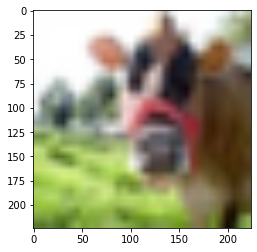

In [4]:
print(train_set[0][0].shape)
plt.imshow(train_set[0][0].permute(1,2,0).numpy()[:,:,::])
plt.show()

In [5]:
in_features = model.heads[0].in_features
in_features

768

In [ ]:
model.heads = nn.Linear(in_features,len(train_set.classes)) # set in_features and out_features
model.train()

In [ ]:
# Freeze other layers unless it is self_attention or mlp_head
for name, param in model.named_parameters():
    if ('mha' in name) or ('head' in name):
        print("Unfreeze " + name)
        param.requires_grad = True
    else:
        print("Freeze " + name)
        param.requires_grad = False

In [8]:
# Reading whole dataloader into memory can improve the speed of training
train_loader = list(train_loader)

In [9]:
loss_function = nn.CrossEntropyLoss()

In [ ]:
lr = lr_base
def adjust_learning_rate(optimizer, current_epoch, max_epoch, lr_min=lr_min, lr_max=lr_base, warmup=True):
    if current_epoch < warmup_epoch:
        lr = lr_max * (current_epoch+1) / (warmup_epoch+1)
    else:
        lr = lr_min + (lr_max-lr_min)*(1 + cos(pi * (current_epoch - warmup_epoch) / (max_epoch - warmup_epoch))) / 2
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    print("Learning rate is set to "+str(lr))

optimiser = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), 
                      lr=lr,
                      momentum=0.9) #only optimse non-frozen layers
model.to(device)

In [ ]:
results = []

for epoch in range(warmup_epoch+num_epoch):
    running_loss = 0
    train_acc = 0
    
    adjust_learning_rate(optimizer=optimiser,
                        current_epoch=epoch,
                        max_epoch=warmup_epoch+num_epoch)
    with tqdm(train_loader, desc='Train(epoch'+str(epoch)+')') as t:
        total = 0
        correct = 0
        for data in t:
            model.train()
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimiser.zero_grad()

            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            running_loss += loss.item()
            loss.backward()
            optimiser.step()
            
            pred = torch.argmax(F.softmax(outputs), dim=1)
            total += len(labels)
            correct += sum(pred == labels)
            
        train_acc = (100.0 * correct) / total

        t.set_postfix(running_loss=running_loss,
                      runing_acc=train_acc)
            
    print("epoch %d/%d:(tr)loss=%.4f" % (epoch, warmup_epoch+num_epoch, running_loss))
    print("epoch %d/%d:(tr)acc=%.4f%%" % (epoch, warmup_epoch+num_epoch, train_acc))
    
    test_running_loss = 0
    test_acc = 0

    with tqdm(test_loader, desc='test'+str(epoch)) as t:
        with torch.no_grad():
            total = 0
            correct = 0
            for data in t:
                model.eval()
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)

                loss = loss_function(outputs, labels)
                test_running_loss += loss.item()
                            
                pred = torch.argmax(F.softmax(outputs), dim=1)
                total += len(labels)
                correct += sum(pred == labels)
            test_acc = (100.0 * correct) / total

            t.set_postfix(running_loss=test_running_loss,
                          runing_acc=test_acc)

    print("epoch %d/%d:(te)loss=%.4f" % (epoch, warmup_epoch+num_epoch, test_running_loss))
    print("epoch %d/%d:(te)acc=%.4f%%" % (epoch, warmup_epoch+num_epoch, test_acc))
          
    results.append({'running_loss':running_loss,
                   'train_acc':train_acc,
                   'test_running_loss':test_running_loss,
                   'test_acc':test_acc})


Learning rate is set to 0.00125


Train(epoch0):   0%|          | 0/782 [00:00<?, ?it/s]

/home/hf5n21/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


epoch 0/10:(tr)loss=1386.7817
epoch 0/10:(tr)acc=63.9440%


test0:   0%|          | 0/157 [00:00<?, ?it/s]

/home/hf5n21/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


epoch 0/10:(te)loss=115.6596
epoch 0/10:(te)acc=79.9400%
Learning rate is set to 0.0025


Train(epoch1):   0%|          | 0/782 [00:00<?, ?it/s]

epoch 1/10:(tr)loss=449.7215
epoch 1/10:(tr)acc=83.2080%


test1:   0%|          | 0/157 [00:00<?, ?it/s]

epoch 1/10:(te)loss=81.4954
epoch 1/10:(te)acc=84.2000%
Learning rate is set to 0.00375


Train(epoch2):   0%|          | 0/782 [00:00<?, ?it/s]

epoch 2/10:(tr)loss=305.0063
epoch 2/10:(tr)acc=88.0620%


test2:   0%|          | 0/157 [00:00<?, ?it/s]

epoch 2/10:(te)loss=76.3754
epoch 2/10:(te)acc=84.8200%
Learning rate is set to 0.005000000000000001


Train(epoch3):   0%|          | 0/782 [00:00<?, ?it/s]

epoch 3/10:(tr)loss=228.2175
epoch 3/10:(tr)acc=91.0020%


test3:   0%|          | 0/157 [00:00<?, ?it/s]

epoch 3/10:(te)loss=78.9188
epoch 3/10:(te)acc=84.7500%
Learning rate is set to 0.0047771799527804425


Train(epoch4):   0%|          | 0/782 [00:00<?, ?it/s]

epoch 4/10:(tr)loss=143.4773
epoch 4/10:(tr)acc=94.4240%


test4:   0%|          | 0/157 [00:00<?, ?it/s]

epoch 4/10:(te)loss=77.7960
epoch 4/10:(te)acc=85.7900%
Learning rate is set to 0.004152852054182151


Train(epoch5):   0%|          | 0/782 [00:00<?, ?it/s]

epoch 5/10:(tr)loss=82.4082
epoch 5/10:(tr)acc=97.0620%


test5:   0%|          | 0/157 [00:00<?, ?it/s]

epoch 5/10:(te)loss=75.4367
epoch 5/10:(te)acc=86.4700%
Learning rate is set to 0.003250672101401708


Train(epoch6):   0%|          | 0/782 [00:00<?, ?it/s]

epoch 6/10:(tr)loss=44.4175
epoch 6/10:(tr)acc=98.6900%


test6:   0%|          | 0/157 [00:00<?, ?it/s]

epoch 6/10:(te)loss=74.6117
epoch 6/10:(te)acc=86.8100%
Learning rate is set to 0.0022493278985982927


Train(epoch7):   0%|          | 0/782 [00:00<?, ?it/s]

epoch 7/10:(tr)loss=23.3319
epoch 7/10:(tr)acc=99.5140%


test7:   0%|          | 0/157 [00:00<?, ?it/s]

epoch 7/10:(te)loss=73.1144
epoch 7/10:(te)acc=87.1900%
Learning rate is set to 0.0013471479458178497


Train(epoch8):   0%|          | 0/782 [00:00<?, ?it/s]

epoch 8/10:(tr)loss=14.7477
epoch 8/10:(tr)acc=99.7680%


test8:   0%|          | 0/157 [00:00<?, ?it/s]

epoch 8/10:(te)loss=74.2975
epoch 8/10:(te)acc=87.2100%
Learning rate is set to 0.0007228200472195571


Train(epoch9):   0%|          | 0/782 [00:00<?, ?it/s]

epoch 9/10:(tr)loss=11.2963
epoch 9/10:(tr)acc=99.8700%


test9:   0%|          | 0/157 [00:00<?, ?it/s]

In [ ]:
results

In [ ]:
torch.save(model.state_dict(), "model/" + model_filename)

In [ ]:
train_loss_list = []
train_acc_list = []
for result in results:
    train_loss_list.append(result["running_loss"])
    train_acc_list.append(torch.Tensor.cpu(result["train_acc"]))

In [ ]:
test_loss_list = []
test_acc_list = []
for result in results:
    test_loss_list.append(result["test_running_loss"])
    test_acc_list.append(torch.Tensor.cpu(result["test_acc"]))

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))

ax[0].plot(train_loss_list)
ax[0].plot(test_loss_list)
ax[0].legend(['train','test'])
ax[0].grid()
ax[0].set_title("Loss")

ax[1].plot(train_acc_list)
ax[1].plot(test_acc_list)
ax[1].legend(['train','test'])
ax[1].grid()
ax[1].set_title("Accuracy")
plt.show()